<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/UNET_NORMAL_FINAL_CROPPED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [3]:
import cv2
from tqdm import tqdm

In [ ]:
def preprocess_image(image_path):
    '''Loads the image given make it ready for
       the model
       Args:
         image_path: Path to the image file
    '''
    image = tf.image.decode_image(tf.io.read_file(image_path))
    if image.shape[-1] == 4:  # If image has an alpha channel
        image = image[..., :-1]  # Remove the alpha channel
    elif image.shape[-1] == 1:  # If image is grayscale
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
    image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
    image = tf.cast(image, tf.float32)
    return tf.expand_dims(image, 0)  # Expand dims to create a batch dimension


def resize_image(image):
    resized_image = cv2.resize(image, (256, 256))
    return resized_image

In [ ]:
def SRGAN(input_path):
    # Load image
    load_image = preprocess_image(input_path)  # Assuming preprocess_image is defined elsewhere

    # Process image using the model
    super_image = model(load_image)  # Assuming model is defined elsewhere

    # Squeeze dimensions
    super_image = tf.squeeze(super_image)

    # Convert processed tensor to NumPy array
    super_image_np = np.array(super_image)

    # Resize NumPy array
    resized_image = resize_image(super_image_np)  # Assuming resize_image is defined elsewhere

    # Overwrite the original image
    cv2.imwrite(input_path, resized_image)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def is_supported_format(filename):
    supported_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    return filename.lower().endswith(supported_formats)

In [ ]:
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Final_Final/Train"):
    for filename in filenames:
        if is_supported_format(filename):
            input_path = os.path.join(dirname, filename)
            SRGAN(input_path)

for dirname, _, filenames in os.walk("/content/drive/MyDrive/Final_Final/Test"):
    for filename in filenames:
        if is_supported_format(filename):  # Check if the file is in a supported format
            input_path = os.path.join(dirname, filename)
            SRGAN(input_path)

In [ ]:
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Final_Final/Train"):
    for filename in filenames:
        os.path.join(dirname, filename)
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Final_Final/Test"):
    for filename in filenames:
        os.path.join(dirname, filename)

In [4]:
# path='/content/model.h5'
# dataset=path.File(path,"r")
# import h5py

im_shape = (256,256)
TRAINING_DIR = "/content/drive/MyDrive/Final_Cropped/Train"
TEST_DIR = "/content/drive/MyDrive/Final_Cropped/Test"
seed = 10
BATCH_SIZE = 128

In [5]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        preprocessing_function=preprocess_input,
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [9]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.0)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 846 images belonging to 3 classes.
Found 211 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Classes: ['Normal', 'Spaghetti', 'Stringing']


KeyboardInterrupt: 

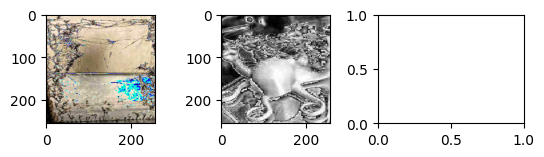

In [10]:
# Assuming `train_generator` is your DirectoryIterator object
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = next(train_generator)[0] * 255
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

UNet

In [11]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import time
def unet(input_img):
    c1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(input_img)
    c2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(c1)
    mp1 = MaxPool2D(pool_size=(2,2))(c2)
    c3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(mp1)
    c4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(c3)
    mp2 = MaxPool2D(pool_size=(2,2))(c4)
    c5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(mp2)
    c6 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(c5)
    mp3 = MaxPool2D(pool_size=(2,2))(c6)
    c7 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(mp3)
    c8 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(c7)
    mp4 = MaxPool2D(pool_size=(2,2))(c8)
    dr1 = Dropout(rate=0.3)(mp4)
    c9 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(dr1)
    c10 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(c9)
    up1 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='valid')(c10)
    merge1 = concatenate([c8, up1])
    c11 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(merge1)
    c12 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(c11)
    up2 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c12)
    merge2 = concatenate([c6, up2])
    c13 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(merge2)
    c14 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(c13)
    up3 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c14)
    merge3 = concatenate([c4, up3])
    c15 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(merge3)
    c16 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(c15)
    up4 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c16)
    merge4 = concatenate([c2, up4])
    c17 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(merge4)
    c18 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(c17)
    return c1
input_img = Input(shape = (256, 256, 3))
x = tf.keras.layers.Flatten()(unet(input_img))
y = tf.keras.layers.Dropout(0.3)(x)
y2 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y)
y3 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y2)
y4 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y3)
y5 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y4)
y6 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y5)
y7 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y6)
y8 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y7)
y9 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y8)
y10 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y9)
y11 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y10)
y12 = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(y11)
z = tf.keras.layers.Dense(3, activation='softmax')(y10)
model = Model(input_img, z)
model.summary()
optimizer = Adam()  # Instantiate Adam optimizer
# m = tf.keras.metrics.SensitivityAtSpecificity(0.5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])  # Use Adam optimizer here
start_time=time.time()
plotter = model.fit(train_generator, validation_data=test_generator, batch_size=128, epochs=50)
training_time = time.time() - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 flatten (Flatten)           (None, 4194304)           0         
                                                                 
 dropout_1 (Dropout)         (None, 4194304)           0         
                                                                 
 dense (Dense)               (None, 256)               1073742080
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792 

1/1 [==============================] - 2s 2s/step - loss: 1.0715 - accuracy: 0.6953
Test Accuracy: 0.70
1/1 [==============================] - 2s 2s/step
Precision: 0.73
Recall: 0.70
F1 Score: 0.69
Specificity: 0.80
AUC-ROC: 0.90


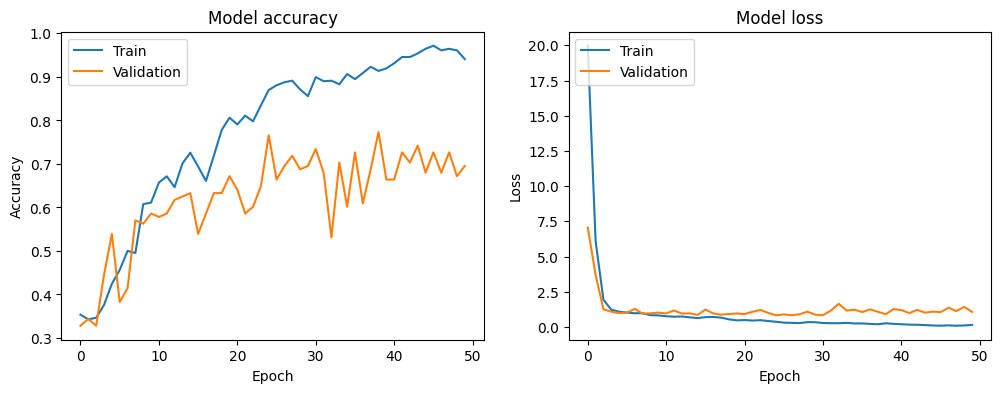

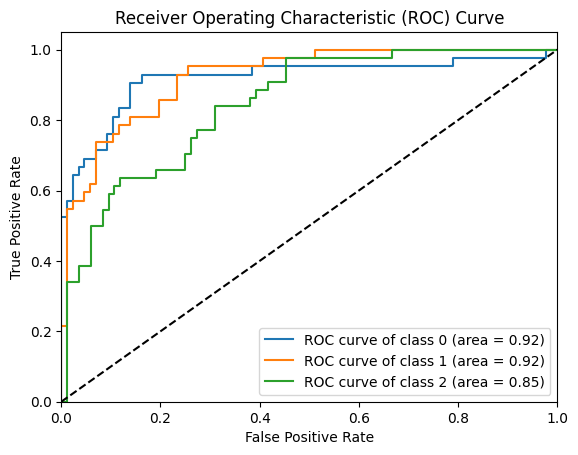

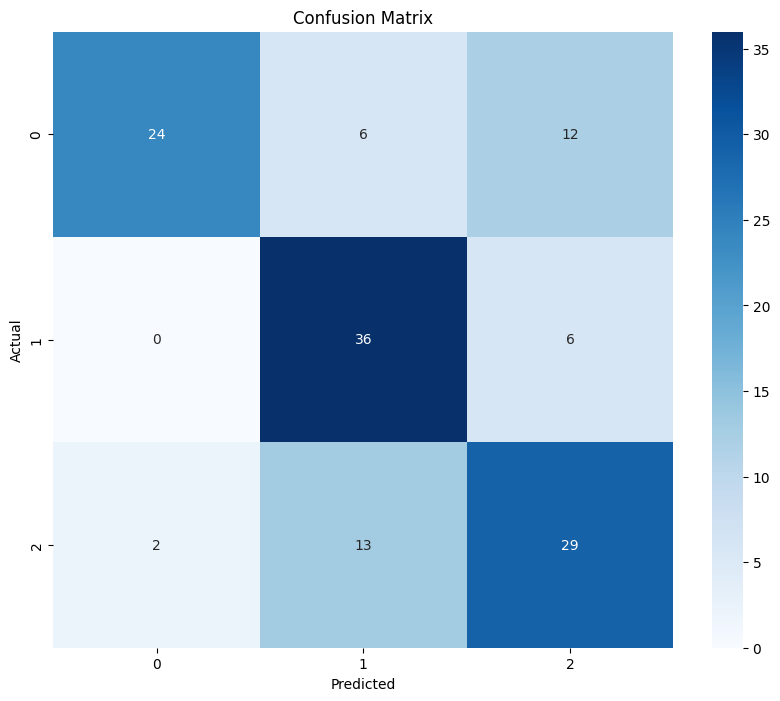

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict the test data
test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes

# Calculate metrics
precision = precision_score(true_classes, test_pred_classes, average='weighted')
recall = recall_score(true_classes, test_pred_classes, average='weighted')  # Sensitivity
f1 = f1_score(true_classes, test_pred_classes, average='weighted')
conf_matrix = confusion_matrix(true_classes, test_pred_classes)

# Calculate specificity
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
tp = conf_matrix[1, 1]
specificity = tn / (tn + fp)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")

# AUC-ROC
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes, num_classes=3), test_preds, multi_class='ovr')
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(plotter.history['accuracy'])
plt.plot(plotter.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(plotter.history['loss'])
plt.plot(plotter.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot ROC curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(tf.keras.utils.to_categorical(true_classes, num_classes=3)[:, i], test_preds[:, i])
    roc_auc[i] = roc_auc_score(tf.keras.utils.to_categorical(true_classes, num_classes=3)[:, i], test_preds[:, i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
import numpy as np
y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred,axis=1)
print(y_pred.shape)
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes,y_pred))
print('Classification Report')

<ipython-input-13-0a9f0e7b1aef>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


(128,)
Confusion Matrix
[[24  6 12]
 [ 0 36  6]
 [ 2 13 29]]
Classification Report


In [14]:
print('Active')

Active


In [15]:
print('Almost done')

Almost done
